In [44]:
# generate trends in OF value by supply type (open/FD) for different ETAs

In [45]:
# Install packages

In [ ]:
%%bash
source $VIRTUAL_ENV_DIR/python3/bin/activate

install_package_python3.sh add dsw_qr==0.1.13

$VIRTUAL_ENV_DIR/python3/bin/python -m pip install galileo
$VIRTUAL_ENV_DIR/python3/bin/python -m pip install galileo-py
$VIRTUAL_ENV_DIR/python3/bin/python -m pip install tchannel

In [ ]:
# fetch data

In [ ]:
import os

import pandas as pd
from dsw_qr import dsw_qr

In [ ]:
USER_EMAIL = 'targupt@uber.com'

QUERY = """select
  msg.supply_type,
  floor(msg.unadjusted_eta / 240),
  count(*) as count,
  avg(msg.unadjusted_eta) as average_eta,
  avg(msg.objective_value) as average_OF_value
from
  rawdata.kafka_hp_multileg_mgv_log_nodedup
where
  datestr between '2022-10-24'
  and '2022-10-30'
  and msg.calculator_type = 'compound_completion_rate_of'
  and abs(
    mod(
      from_big_endian_64(xxhash64(CAST(msg.job_uuid AS varbinary))),
      100
    )
  ) <= {{sample_percentage}}
  and msg.unadjusted_eta < 3000
group by
  msg.supply_type,
  floor(msg.unadjusted_eta / 240)"""

In [ ]:
from queryrunner_client import Client
qr = Client(user_email='targupt@uber.com')
qr.list_datasources()
cursor = qr.execute("hive", QUERY)
result = cursor.fetchall()

In [ ]:
pd.DataFrame(result).to_csv("of_value_supply_type_eta.csv", index=False)

In [ ]:
# generate plot

In [ ]:
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("of_value_supply_type_eta.csv") #https://querybuilder.uberinternal.com/r/sJd6k0RiZ

In [ ]:
data.columns

In [ ]:
o = data[data.supply_type == 'open']
o = dict(zip(o._col1, o.average_OF_value))

f = data[data.supply_type == 'forwardDispatch']
f = dict(zip(f._col1, f.average_OF_value))


In [ ]:
[f[i] for i in range(10)]

Text(0.5,1,'Trends in average OF value by supply type for different ETAs')

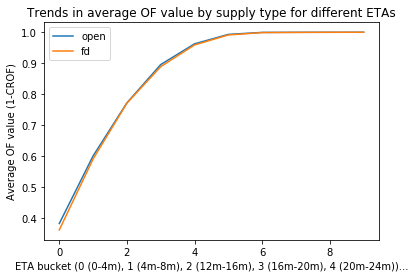

In [23]:
plt.plot(range(10), [o[i] for i in range(10)], label='open')
plt.plot(range(10), [f[i] for i in range(10)], label='fd')
plt.legend()
plt.xlabel("ETA bucket (0 (0-4m), 1 (4m-8m), 2 (12m-16m), 3 (16m-20m), 4 (20m-24m))...")
plt.ylabel("Average OF value (1-CROF)")
plt.title("Trends in average OF value by supply type for different ETAs")